In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import pickle
import joblib
from mplsoccer.pitch import Pitch
from ipynb.fs.defs.ExpectedGoalsData import get_df_shots
from ipynb.fs.defs.PassesData import get_df_passes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [4]:
plt.style.use('fivethirtyeight')
params = {'axes.titlesize': 'x-large',
          'axes.labelsize': 'large', 
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
plt.rcParams.update(params)

In [5]:
# select the team and player to be analysed
comp_id = 2
team_id = 1
team_name = 'Arsenal'
player_id = 15516
player_name = 'Thierry Henry'

In [6]:
matches = pd.read_excel('extracted_data/matches.xlsx')
players = pd.read_excel('extracted_data/players.xlsx')

In [7]:
def get_player_name(player_id):
    if pd.notna(players.loc[players['player_id'] == player_id, 'player_nickname'].iloc[0]):
        return players.loc[players['player_id'] == player_id, 'player_nickname'].iloc[0]
    else:
        return players.loc[players['player_id'] == player_id, 'player_name'].iloc[0]

In [38]:
def get_competition_shots(competition_id):
    wc_matches = matches[matches['competition_id'] == competition_id]
    events_folder = 'data/events'
    events = pd.concat([pd.DataFrame(json.load(open(os.path.join(events_folder, str(match_id) + '.json'), encoding='utf8'))).assign(match_id=match_id) for match_id in wc_matches['match_id'].unique()])
    events.reset_index(inplace=True)
    comp_shots = get_df_shots(events)
    xg_model = joblib.load('models/expected_goals_model.pkl')
    with open("models/xg_selected_features.txt", "rb") as fp:
         xg_selected_features = pickle.load(fp)
    comp_shots.loc[:, 'pred_xg'] = xg_model.predict_proba(comp_shots[xg_selected_features])[:, 1]
    
    comp_shots.loc[:, 'from_pressing'] = 0
    for idx, row in comp_shots.iterrows():
        if row['second'] >= 8:
            prev_events = events[(events['match_id'] == row['match_id']) & (events['minute'] == row['minute']) & (events['second'].between(row['second']-8, row['second']))]
        else:
            prev_events = events[(events['match_id'] == row['match_id']) & (((events['minute'] == row['minute']) & (events['second'] <= row['second'])) | ((events['minute'] == row['minute']-1) & (events['second'].between(60+row['second']-8, 60))))]
        if prev_events['counterpress'].sum() > 0:
            comp_shots.loc[idx, 'from_pressing'] = 1
    comp_shots.loc[(comp_shots['from_pressing'] == 1) & (comp_shots['open_play'] == 0), 'from_pressing'] = 0
    # calculate goal distance in meters
    comp_shots.loc[:, 'goal_distance_m'] = [np.sqrt(np.square((120-comp_shots['location_x'].iloc[i])/120*105) + np.square((40-comp_shots['location_y'].iloc[i])/80*70)) for i in range(len(comp_shots))]
    
    return comp_shots

In [9]:
def get_competition_passes(competition_id):
    wc_matches = matches[matches['competition_id'] == competition_id]
    events_folder = 'data/events'
    events = pd.concat([pd.DataFrame(json.load(open(os.path.join(events_folder, str(match_id) + '.json'), encoding='utf8'))).assign(match_id=match_id) for match_id in wc_matches['match_id'].unique()])
    events.reset_index(inplace=True)
    comp_passes = get_df_passes(events)
    xg_model = joblib.load('models/pass_accuracy_model.pkl')
    with open("models/passes_selected_features.txt", "rb") as fp:
         passes_selected_features = pickle.load(fp)
    comp_passes.loc[:, 'pred_accuracy'] = xg_model.predict_proba(comp_passes[passes_selected_features])[:, 1]
    return comp_passes

Analyse der Torerzielung einzelner Spieler und Mannschaften

In [39]:
# get shots and passes for Arsenal's Premier League season 2003/04
comp_shots = get_competition_shots(comp_id)
shots = comp_shots[comp_shots['team_id'] == team_id]
comp_passes = get_competition_passes(comp_id)
passes = comp_passes[comp_passes['team_id'] == team_id]

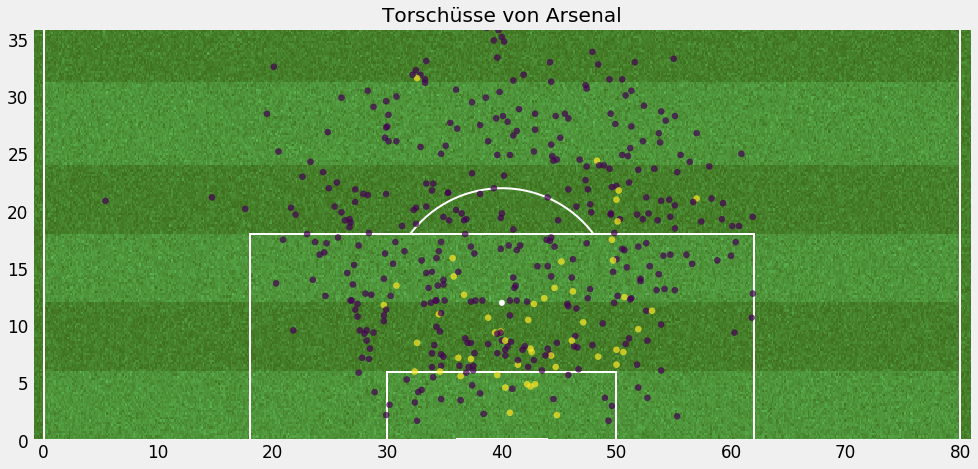

In [12]:
open_shots = shots[shots['open_play'] == 1]
pitch = Pitch(figsize=(15,8), pitch_color='grass', line_color='white', stripe=True, axis=True, label=True, tick=True,
              orientation='vertical', tight_layout=False)
fig, ax = pitch.draw()
ax.scatter(80-open_shots['location_y'], 120-open_shots['location_x'], c=open_shots['goal'], alpha=0.7)
plt.ylim(0,36)
plt.xlim(-1,81)
plt.title('Torschüsse von ' + team_name)
plt.show()

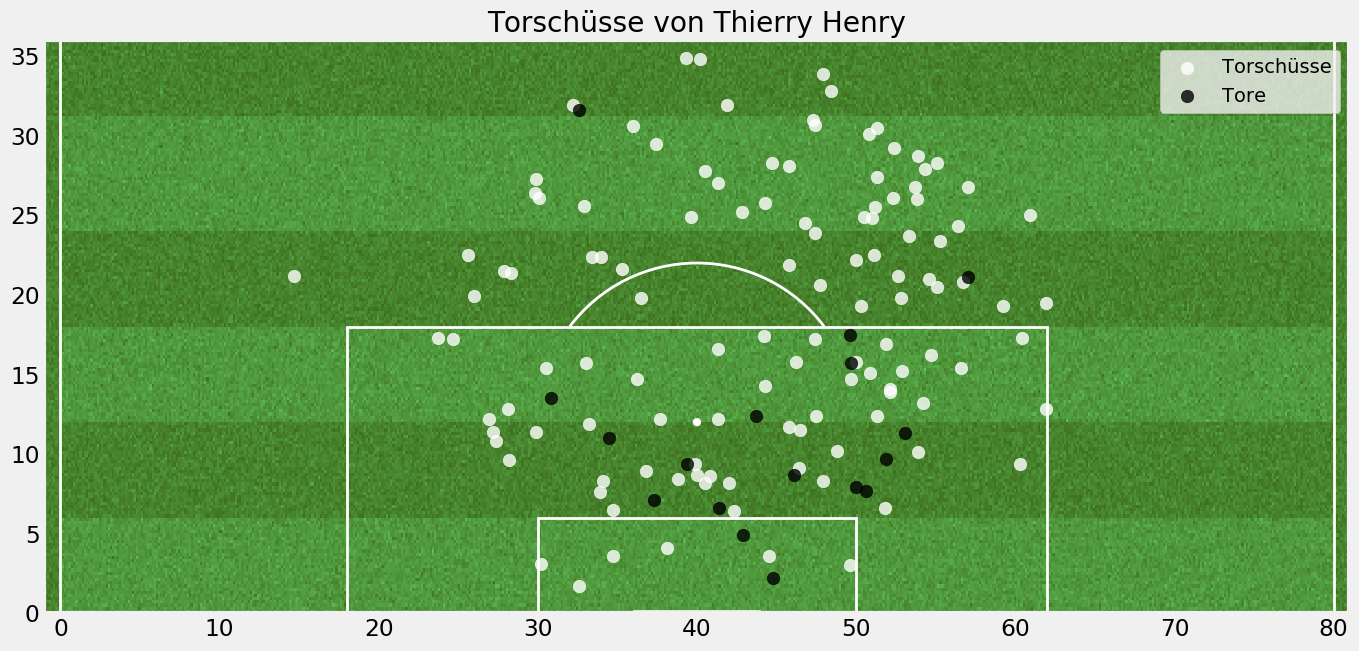

In [115]:
player_open_shots = shots[(shots['player_id'] == player_id) & (shots['open_play'] == 1) & (shots['goal'] == 0)]
player_open_goals = shots[(shots['player_id'] == player_id) & (shots['open_play'] == 1) & (shots['goal'] == 1)]
pitch = Pitch(figsize=(15,8), pitch_color='grass', line_color='white', stripe=True, axis=True, label=True, tick=True,
              orientation='vertical', tight_layout=False)
fig, ax = pitch.draw()
ax.scatter(80-player_open_shots['location_y'], 120-player_open_shots['location_x'], alpha=0.8, s=80, color='white', label='Torschüsse')
ax.scatter(80-player_open_goals['location_y'], 120-player_open_goals['location_x'], alpha=0.8, s=80, color='black', label='Tore')
plt.ylim(0,36)
plt.xlim(-1,81)
plt.title('Torschüsse von ' + player_name)
plt.legend()
plt.show()

In [98]:
shot_assists.head()

,duration,match_id,minute,period,position,second,under_pressure,recipient,length,angle,end_location_x,end_location_y,backheel,deflected,miscommunication,cross,cut_back,switch,shot_assist,goal_assist,team_id,player_id,location_x,location_y,ground_pass,low_pass,high_pass,drop_kick,head,keeper_arm,left_foot,right_foot,no_touch,corner,free_kick,goal_kick,interception,kick_off,recovery,throw_in,incomplete,injury_clearance,out,pass_offside,complete,inswinging,outswinging,straight,through_ball,pred_accuracy
42,1.516150,3749257,3,1,13,11,0,40221,19.337269,-1.632893,75.1,42.7,0,0,0,0,0,0,1,0,1,15515,76.3,62.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.982200
95,1.097856,3749257,7,1,22,18,0,15516,21.402103,-2.200280,84.8,22.4,0,0,0,0,0,0,1,0,1,15042,97.4,39.7,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.941782
106,1.330563,3749257,8,1,22,10,1,15754,24.205164,1.328824,97.7,46.8,0,0,0,0,0,0,1,0,1,15042,91.9,23.3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.810591
352,1.159503,3749257,31,1,13,16,0,15042,25.456825,0.315539,105.0,45.9,0,0,0,0,0,0,1,0,1,15515,80.8,38.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.535577
361,0.815234,3749257,32,1,24,14,0,15042,3.373426,1.361773,100.4,41.8,0,0,0,0,0,0,1,0,1,15516,99.7,38.5,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0.549097


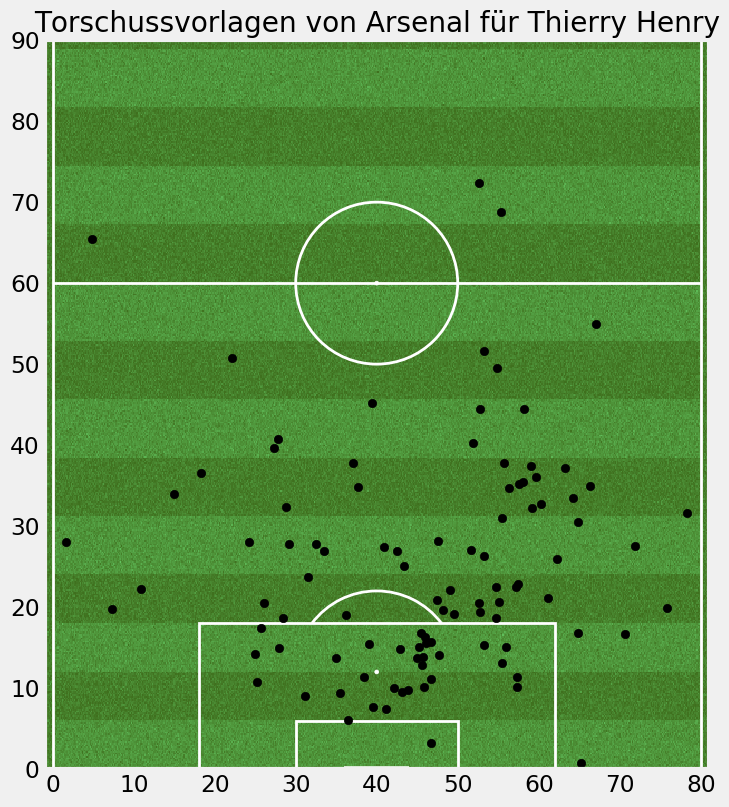

In [110]:
open_shot_assists = shot_assists[(shot_assists['corner'] == 0) & (shot_assists['free_kick'] == 0) & 
                                 (shot_assists['goal_kick'] == 0) & (shot_assists['kick_off'] == 0) & 
                                 (shot_assists['throw_in'] == 0) & (shot_assists['recipient'] == player_id)]
player_open_shots = shots[(shots['player_id'] == player_id) & (shots['open_play'] == 1)]
pitch = Pitch(figsize=(12,9), pitch_color='grass', line_color='white', stripe=True, axis=True, label=True, tick=True,
              orientation='vertical', tight_layout=False)
fig, ax = pitch.draw()
ax.scatter(80-open_shot_assists['end_location_y'], 120-open_shot_assists['end_location_x'], color='black')
plt.ylim(0,90)
plt.xlim(-1,81)
plt.title('Torschussvorlagen von ' + team_name + ' für ' + player_name)
plt.show()

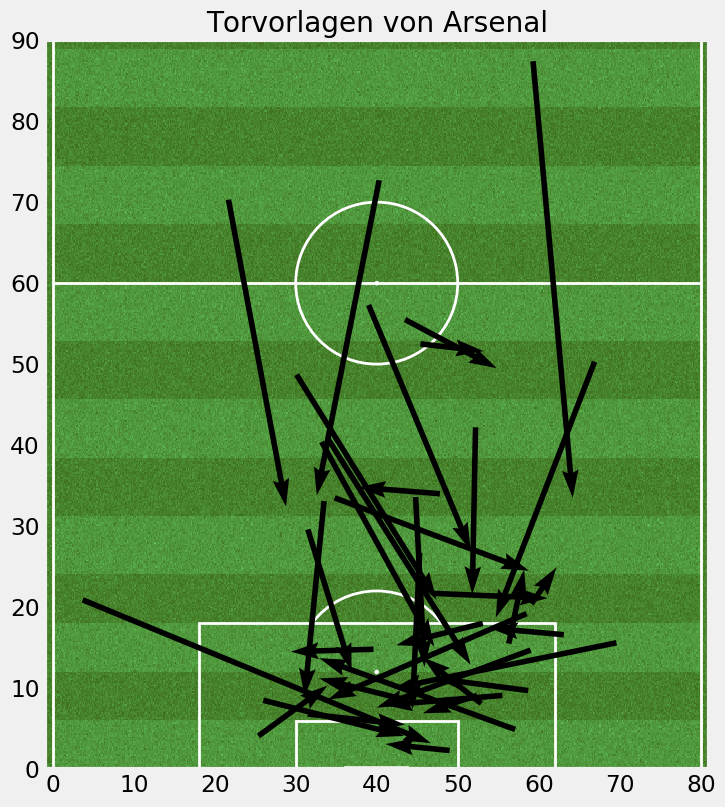

In [76]:
open_goal_assists = goal_assists[(goal_assists['corner'] == 0) & (goal_assists['free_kick'] == 0) & 
                                 (goal_assists['goal_kick'] == 0) & (goal_assists['kick_off'] == 0) & 
                                 (goal_assists['throw_in'] == 0)]
open_goals = goals[goals['open_play'] == 1]
pitch = Pitch(figsize=(12,9), pitch_color='grass', line_color='white', stripe=True, axis=True, label=True, tick=True,
              orientation='vertical', tight_layout=False)
fig, ax = pitch.draw()
for idx, assist in open_goal_assists.iterrows():
    pitch.arrows(120-assist['location_x'], 80-assist['location_y'], 120-assist['end_location_x'], 80-assist['end_location_y'], ax=ax)
plt.ylim(0,90)
plt.xlim(-1,81)
plt.title('Torvorlagen von ' + team_name)
plt.show()

Gefährliche Spielfeldzonen

In [14]:
shots_zone1 = shots[(shots['location_x'] >= 114) & (shots['location_y'].between(30,50))]
shots_zone2 = shots[(shots['location_x'].between(108, 113.999)) & (shots['location_y'].between(30,50))]
shots_zone3 = shots[(shots['location_x'].between(102, 107.999)) & (shots['location_y'].between(30,50))]
shots_zone4 = shots[(shots['location_x'] >= 114) & ((shots['location_y'].between(18, 29.999)) | (shots['location_y'].between(50.001, 62)))]
shots_zone5 = shots[(shots['location_x'].between(102, 113.999)) & ((shots['location_y'].between(18, 29.999)) | (shots['location_y'].between(50.001, 62)))]
shots_zone6 = shots[(shots['location_x'] < 102) & (shots['location_y'].between(30,50))]
shots_zone7 = shots[(shots['location_x'] < 102) & ((shots['location_y'].between(18, 29.999)) | (shots['location_y'].between(50.001, 62)))]
shots_zone8 = shots[(shots['location_x'] >= 102) & ((shots['location_y'] < 18) | (shots['location_y'] > 62))]
shots_zone9 = shots[(shots['location_x'] < 102) & ((shots['location_y'] < 18) | (shots['location_y'] > 62))]

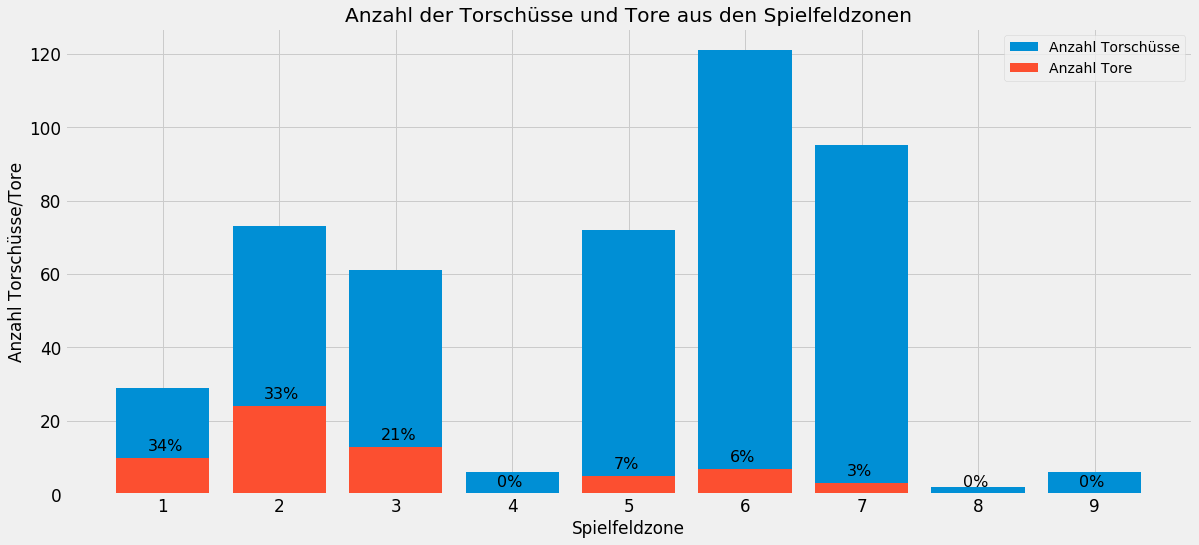

In [15]:
# Torschüsse und Tore in Abhängigkeit der Spielfeldzone
shots_zonen = [shots_zone1, shots_zone2, shots_zone3, shots_zone4, shots_zone5, shots_zone6, shots_zone7, shots_zone8, shots_zone9]
num_goals = [len(shots_zone[shots_zone['goal'] == 1]) for shots_zone in shots_zonen]
num_shots = [len(shots_zone) for shots_zone in shots_zonen]
pct_scored = [int(np.round(100 * num_goals[i] / num_shots[i])) for i in range(len(num_shots))]
plt.figure(figsize=(18,8))
plt.bar(x=[str(i) for i in np.arange(1, len(shots_zonen)+1)], height=num_shots, label='Anzahl Torschüsse')
plt.bar(x=[str(i) for i in np.arange(1, len(shots_zonen)+1)], height=num_goals, label='Anzahl Tore')
for i in range(len(shots_zonen)):
    plt.text(i - 0.13, num_goals[i] + 2, str(pct_scored[i]) + '%', fontsize=16)
plt.title('Anzahl der Torschüsse und Tore aus den Spielfeldzonen')
plt.xlabel('Spielfeldzone')
plt.ylabel('Anzahl Torschüsse/Tore')
plt.legend()
plt.show()

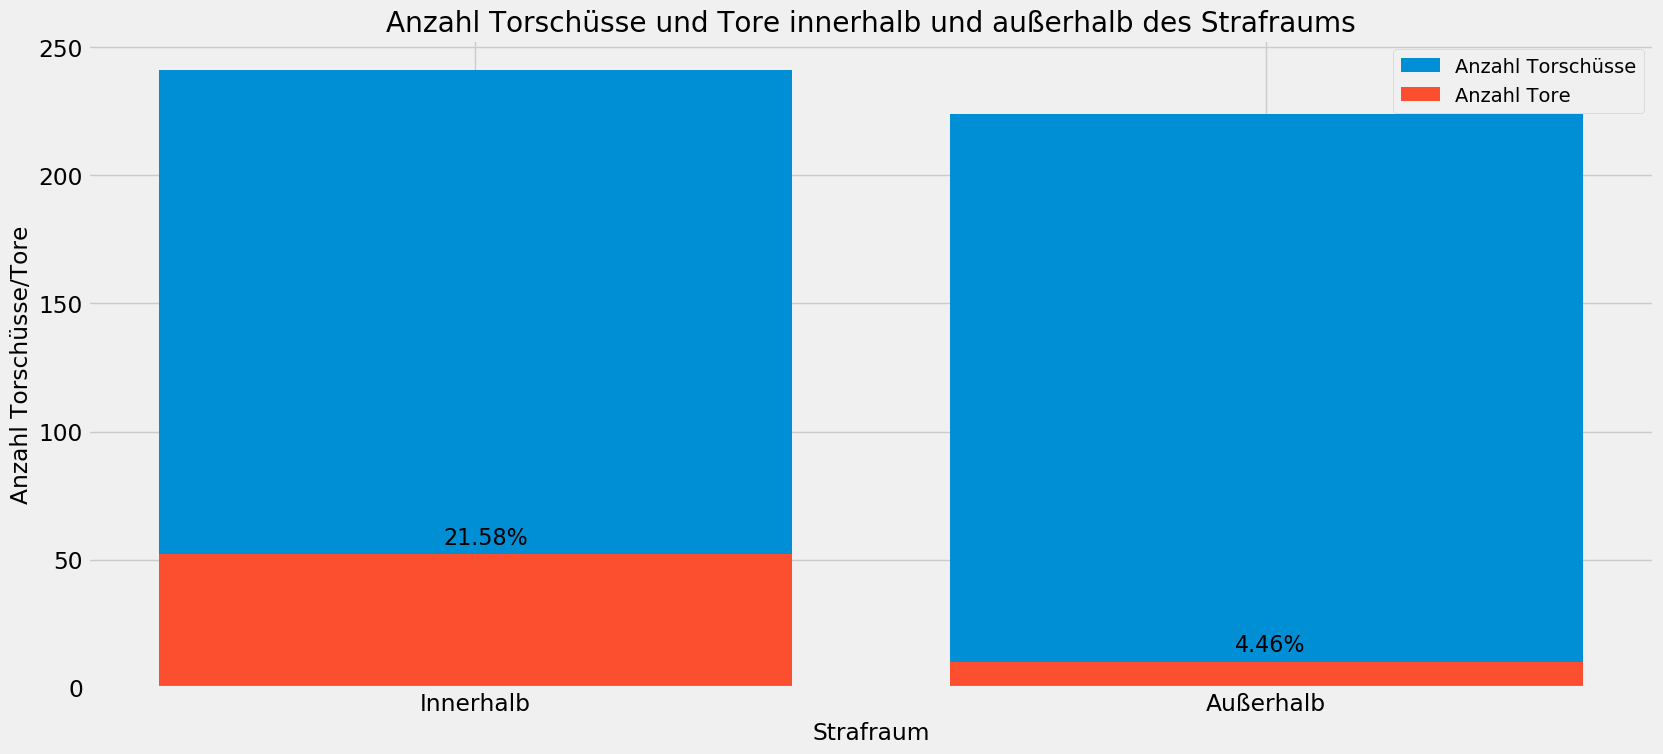

In [84]:
shots_inside_box = pd.concat([shots_zone1, shots_zone2, shots_zone3, shots_zone4, shots_zone5])
shots_outside_box = pd.concat([shots_zone6, shots_zone7, shots_zone8, shots_zone9])
shots_box = [shots_inside_box, shots_outside_box]
num_goals = [len(shots_boxx[shots_boxx['goal'] == 1]) for shots_boxx in shots_box]
num_shots = [len(shots_boxx) for shots_boxx in shots_box]
pct_scored = [np.round(100 * num_goals[i] / num_shots[i], 2) for i in range(len(num_shots))]
plt.figure(figsize=(18,8))
plt.bar(x=['Innerhalb', 'Außerhalb'], height=num_shots, label='Anzahl Torschüsse')
plt.bar(x=['Innerhalb', 'Außerhalb'], height=num_goals, label='Anzahl Tore')
for i in range(len(shots_box)):
    plt.text(i - 0.04, num_goals[i] + 4, str(pct_scored[i]) + '%', fontsize=16)
plt.title('Anzahl Torschüsse und Tore innerhalb und außerhalb des Strafraums')
plt.xlabel('Strafraum')
plt.ylabel('Anzahl Torschüsse/Tore')
plt.legend()
plt.show()

In [17]:
shot_assists = passes[(passes['shot_assist'] == 1) | (passes['goal_assist'] == 1)]
shot_assists_zone1 = shot_assists[(shot_assists['location_x'] >= 114) & (shot_assists['location_y'].between(30,50))]
shot_assists_zone2 = shot_assists[(shot_assists['location_x'].between(108, 113.999)) & (shot_assists['location_y'].between(30,50))]
shot_assists_zone3 = shot_assists[(shot_assists['location_x'].between(102, 107.999)) & (shot_assists['location_y'].between(30,50))]
shot_assists_zone4 = shot_assists[(shot_assists['location_x'] >= 114) & ((shot_assists['location_y'].between(18, 29.999)) | (shot_assists['location_y'].between(50.001, 62)))]
shot_assists_zone5 = shot_assists[(shot_assists['location_x'].between(102, 113.999)) & ((shot_assists['location_y'].between(18, 29.999)) | (shot_assists['location_y'].between(50.001, 62)))]
shot_assists_zone6 = shot_assists[(shot_assists['location_x'] < 102) & (shot_assists['location_y'].between(30,50))]
shot_assists_zone7 = shot_assists[(shot_assists['location_x'] < 102) & ((shot_assists['location_y'].between(18, 29.999)) | (shot_assists['location_y'].between(50.001, 62)))]
shot_assists_zone8 = shot_assists[(shot_assists['location_x'] >= 102) & ((shot_assists['location_y'] < 18) | (shot_assists['location_y'] > 62))]
shot_assists_zone9 = shot_assists[(shot_assists['location_x'] < 102) & ((shot_assists['location_y'] < 18) | (shot_assists['location_y'] > 62))]

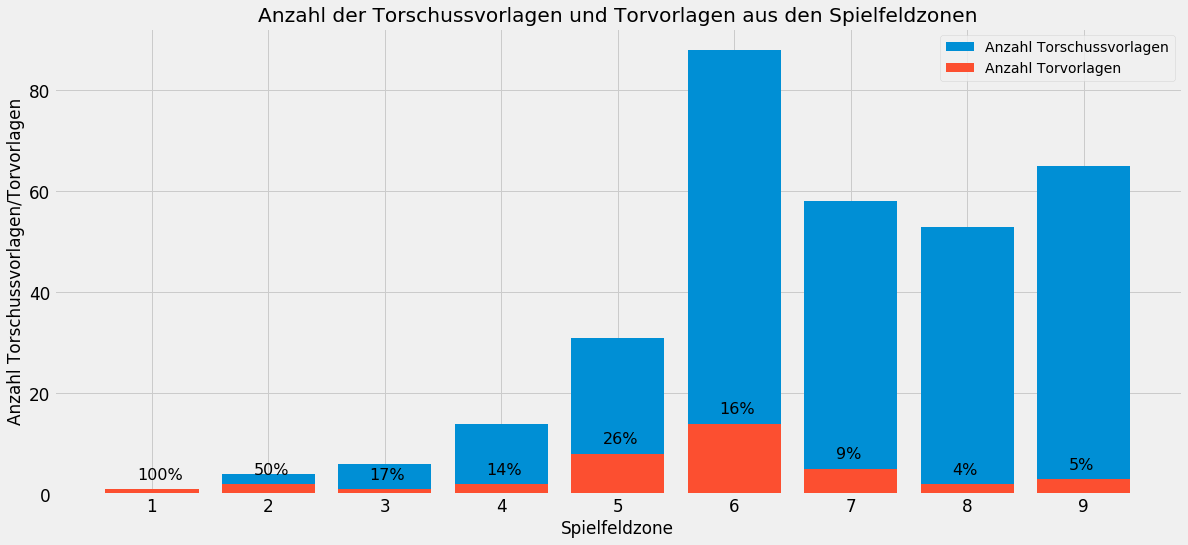

In [18]:
# Torschussvorlagen und Torvorlagen in Abhängigkeit der Spielfeldzone
shot_assists_zonen = [shot_assists_zone1, shot_assists_zone2, shot_assists_zone3, shot_assists_zone4, shot_assists_zone5, shot_assists_zone6, shot_assists_zone7, shot_assists_zone8, shot_assists_zone9]
num_goal_assists = [len(shot_assists_zone[shot_assists_zone['goal_assist'] == 1]) for shot_assists_zone in shot_assists_zonen]
num_shot_assists = [len(shot_assists_zone) for shot_assists_zone in shot_assists_zonen]
pct_scored = [int(np.round(100 * num_goal_assists[i] / num_shot_assists[i])) for i in range(len(num_shot_assists))]
plt.figure(figsize=(18,8))
plt.bar(x=[str(i) for i in np.arange(1, len(shot_assists_zonen)+1)], height=num_shot_assists, label='Anzahl Torschussvorlagen')
plt.bar(x=[str(i) for i in np.arange(1, len(shot_assists_zonen)+1)], height=num_goal_assists, label='Anzahl Torvorlagen')
for i in range(len(shot_assists_zonen)):
    plt.text(i - 0.13, num_goal_assists[i] + 2, str(pct_scored[i]) + '%', fontsize=16)
plt.title('Anzahl der Torschussvorlagen und Torvorlagen aus den Spielfeldzonen')
plt.xlabel('Spielfeldzone')
plt.ylabel('Anzahl Torschussvorlagen/Torvorlagen')
plt.legend()
plt.show()

In [19]:
def get_zone(location_x, location_y):
    if (location_x >= 114) & (30 <= location_y <= 50):
        return 1
    if (108 <= location_x < 114) & (30 <= location_y <= 50):
        return 2
    if (102 <= location_x < 108) & (30 <= location_y <= 50):
        return 3
    if (location_x >= 114) & ((18 <= location_y < 30) | (50 < location_y <= 62)):
        return 4
    if (102 <= location_x < 114) & ((18 <= location_y < 30) | (50 < location_y <= 62)):
        return 5
    if (location_x < 102) & (30 <= location_y <= 50):
        return 6
    if (location_x < 102) & ((18 <= location_y < 30) | (50 < location_y <= 62)):
        return 7
    if (location_x >= 102) & ((location_y < 18) | (location_y > 62)):
        return 8
    if (location_x < 102) & ((location_y < 18) | (location_y > 62)):
        return 9
    return -1

In [79]:
shot_assists = passes[(passes['shot_assist'] == 1) | (passes['goal_assist'] == 1)]
shot_assists.loc[:, 'from_zone'] = [get_zone(shot_assists['location_x'].iloc[i], shot_assists['location_y'].iloc[i]) for i in range(len(shot_assists))]
shot_assists.loc[:, 'to_zone'] = [get_zone(shot_assists['end_location_x'].iloc[i], shot_assists['end_location_y'].iloc[i]) for i in range(len(shot_assists))]

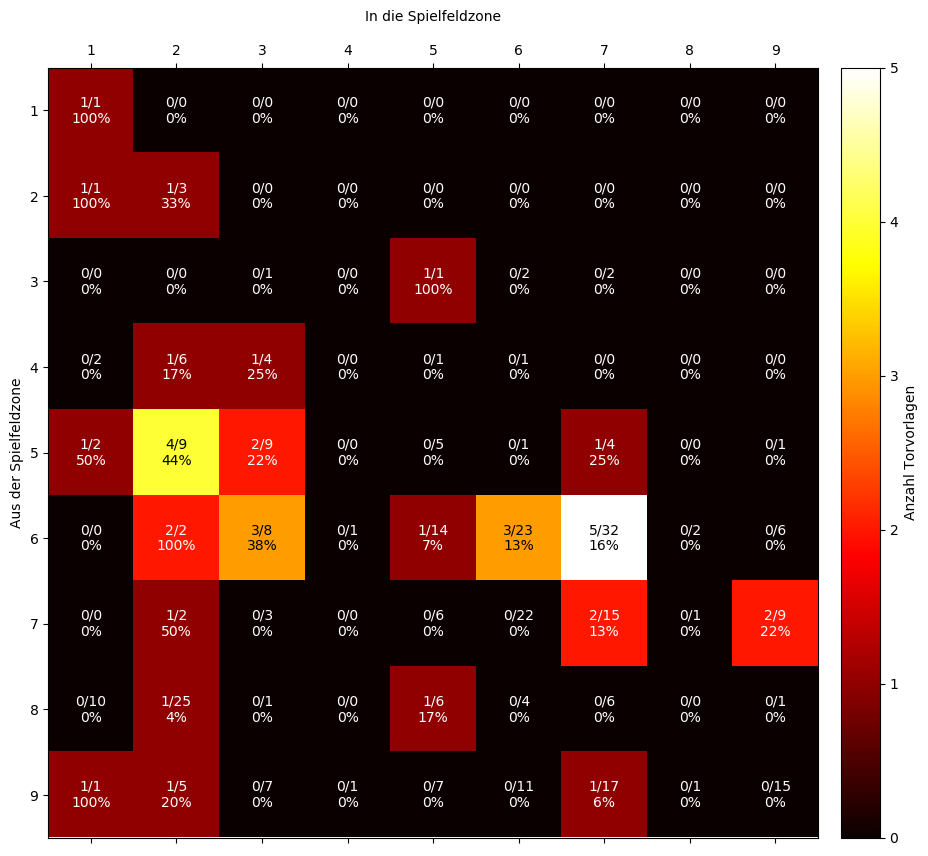

In [80]:
# Anzahl der Torvorlagen von einer Spielfeldzone in eine andere Spielfeldzone
shot_assist_matrix = pd.DataFrame(columns=np.arange(1,10), index=np.arange(1,10))
for col in shot_assist_matrix.columns:
    for idx in shot_assist_matrix.index:
        shot_assist_matrix.loc[idx, col] = len(shot_assists[(shot_assists['from_zone'] == int(idx)) & (shot_assists['to_zone'] == int(col))])

goal_assists = shot_assists[shot_assists['goal_assist'] == 1]
goal_assist_matrix = pd.DataFrame(columns=np.arange(1,10), index=np.arange(1,10))
for col in goal_assist_matrix.columns:
    for idx in goal_assist_matrix.index:
        goal_assist_matrix.loc[idx, col] = len(goal_assists[(goal_assists['from_zone'] == int(idx)) & (goal_assists['to_zone'] == int(col))])

pct_assist_matrix = pd.DataFrame(columns=np.arange(1,10), index=np.arange(1,10))
for col in pct_assist_matrix.columns:
    for idx in pct_assist_matrix.index:
        num_shot_assists = len(shot_assists[(shot_assists['from_zone'] == int(idx)) & (shot_assists['to_zone'] == int(col))])
        num_goal_assists = len(goal_assists[(goal_assists['from_zone'] == int(idx)) & (goal_assists['to_zone'] == int(col))])
        if num_shot_assists > 0:
            pct_assist_matrix.loc[idx, col] = int(np.round(100 * num_goal_assists / num_shot_assists))
        else:
            pct_assist_matrix.loc[idx, col] = 0
        
plt.style.use('default')
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cax = ax.matshow(goal_assist_matrix, cmap='hot')
for (i, j), z in np.ndenumerate(goal_assist_matrix):
    text_color = 'white'
    if z >= np.max(goal_assist_matrix).max() * 0.6:
        text_color = 'black'
    ax.text(j, i, str(z) + '/' + str(shot_assist_matrix[j+1][i+1]) + '\n' + str(pct_assist_matrix[j+1][i+1]) + '%', ha='center', va='center', color=text_color)
fig.colorbar(cax, label='Anzahl Torvorlagen', pad=0.015)
ticks = np.arange(0, len(goal_assist_matrix.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(goal_assist_matrix.columns)
ax.set_yticklabels(goal_assist_matrix.columns)
ax.set_ylabel('Aus der Spielfeldzone', fontsize=10)
ax.set_title('In die Spielfeldzone', fontsize=10)
plt.show()

In [82]:
plt.style.use('fivethirtyeight')
params = {'axes.titlesize': 'x-large',
          'axes.labelsize': 'large', 
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
plt.rcParams.update(params)

Analyse von Angriffsmustern

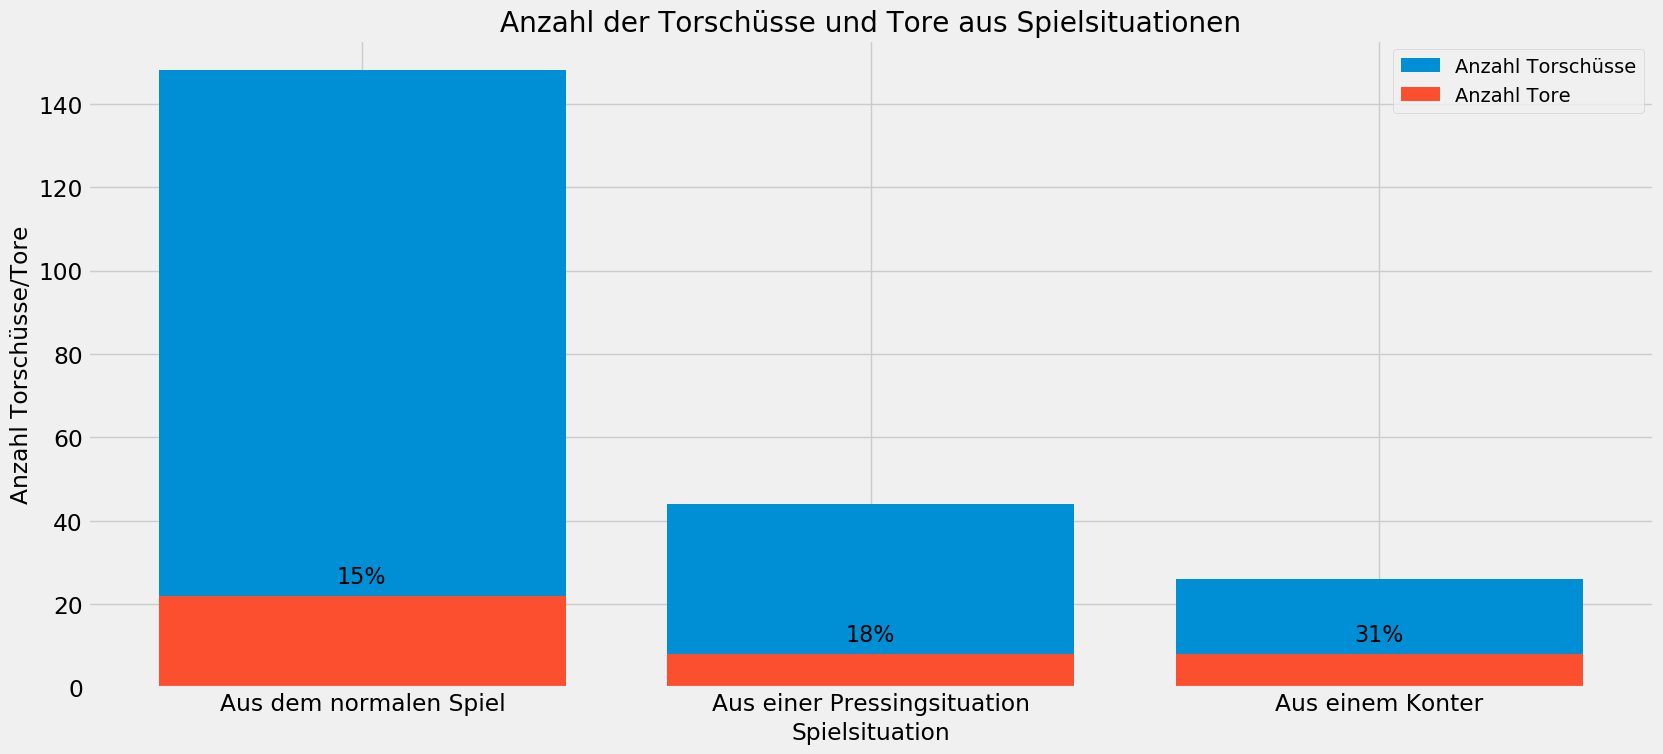

In [92]:
# Torschüsse und Tore in Abhängigkeit der Spielsituation
situations = ['regular_play', 'from_pressing', 'from_counter']
goals = shots[shots['goal'] == 1]
num_goals = [len(goals[goals[situation] == 1]) if situation != 'from_pressing' else len(goals[(goals['from_pressing'] == 1) & (goals['from_counter'] == 0)]) for situation in situations]
num_shots = [len(shots[shots[situation] == 1]) if situation != 'from_pressing' else len(shots[(shots['from_pressing'] == 1) & (shots['from_counter'] == 0)]) for situation in situations]
pct_scored = [int(np.round(100 * num_goals[i] / num_shots[i])) for i in range(len(num_shots))]
plt.figure(figsize=(18,8))
x_labels = ['Aus dem normalen Spiel', 'Aus einer Pressingsituation', 'Aus einem Konter']
plt.bar(x=x_labels, height=num_shots, label='Anzahl Torschüsse')
plt.bar(x=x_labels, height=num_goals, label='Anzahl Tore')
for i in range(len(situations)):
    plt.text(i - 0.05, num_goals[i] + 3, str(pct_scored[i]) + '%', fontsize=16)
plt.title('Anzahl der Torschüsse und Tore aus Spielsituationen')
plt.xlabel('Spielsituation')
plt.ylabel('Anzahl Torschüsse/Tore')
plt.legend()
plt.show()

In [43]:
# passes from open_play
open_passes = passes[(passes['corner'] == 0) & (passes['free_kick'] == 0) & (passes['goal_kick'] == 0) & (passes['kick_off'] == 0) & (passes['throw_in'] == 0)]

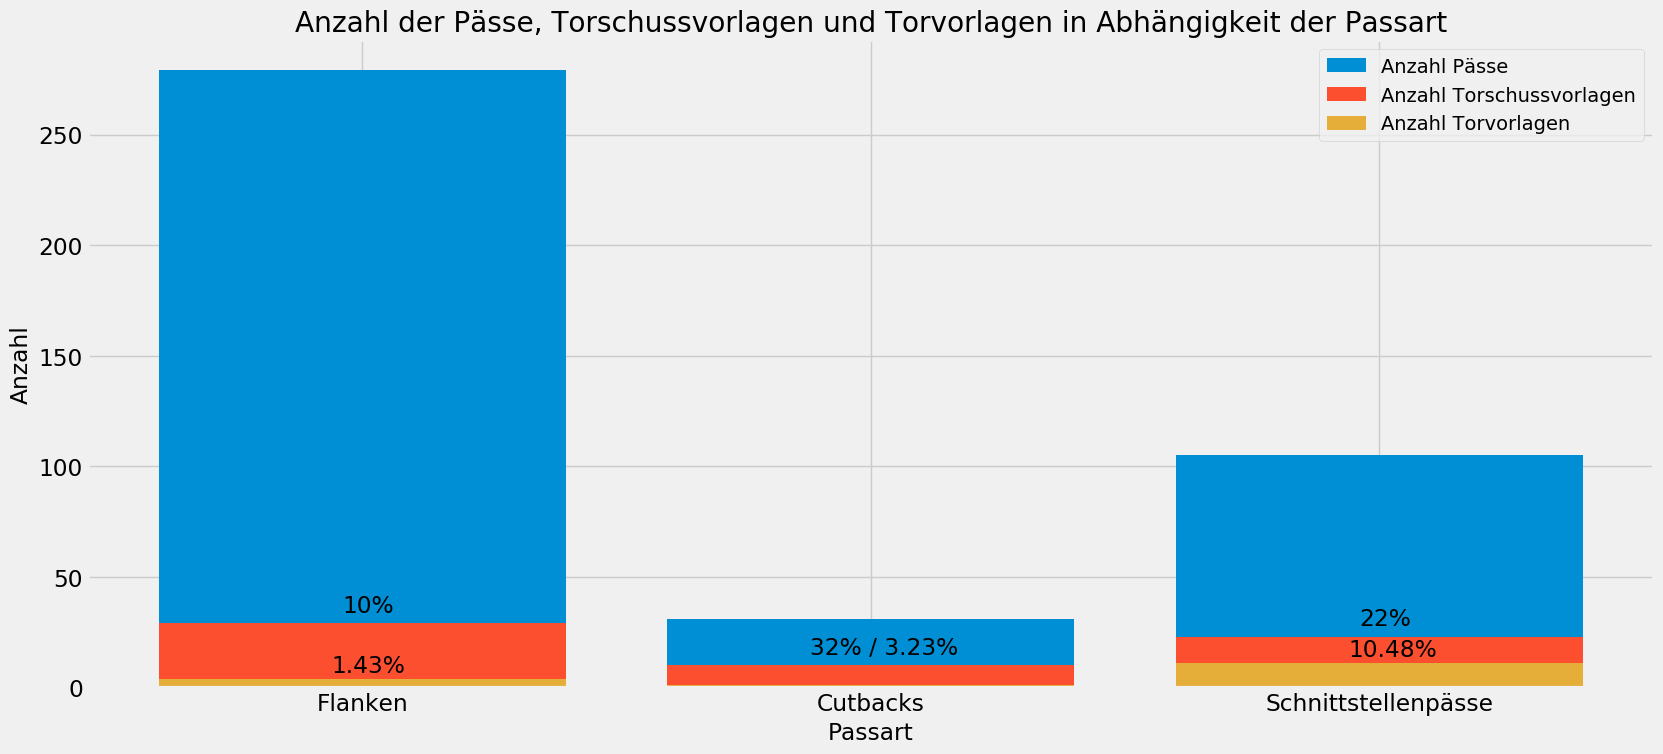

In [89]:
# Torschüsse und Tore in Abhängigkeit der Passart
situations = ['cross', 'cut_back', 'through_ball']
shot_assists = open_passes[(open_passes['shot_assist'] == 1) | (open_passes['goal_assist'] == 1)]
goal_assists = open_passes[open_passes['goal_assist'] == 1]
num_shot_assists = [len(shot_assists[shot_assists[situation] == 1]) if situation != 'cross' else len(shot_assists[(shot_assists['cross'] == 1) & (shot_assists['cut_back'] == 0)]) for situation in situations]
num_goal_assists = [len(goal_assists[goal_assists[situation] == 1]) if situation != 'cross' else len(goal_assists[(goal_assists['cross'] == 1) & (goal_assists['cut_back'] == 0)]) for situation in situations]
num_passes = [len(open_passes[open_passes[situation] == 1]) if situation != 'cross' else len(open_passes[(open_passes['cross'] == 1) & (open_passes['cut_back'] == 0)]) for situation in situations]
pct_shot = [int(np.round(100 * num_shot_assists[i] / num_passes[i])) for i in range(len(num_passes))]
pct_scored = [np.round(100 * num_goal_assists[i] / num_passes[i], 2) for i in range(len(num_passes))]
plt.figure(figsize=(18,8))
x_labels = ['Flanken', 'Cutbacks', 'Schnittstellenpässe']
plt.bar(x=x_labels, height=num_passes, label='Anzahl Pässe')
plt.bar(x=x_labels, height=num_shot_assists, label='Anzahl Torschussvorlagen')
plt.bar(x=x_labels, height=num_goal_assists, label='Anzahl Torvorlagen')
for i in [0,2]:
    plt.text(i - 0.06, num_goal_assists[i] + 3, str(pct_scored[i]) + '%', fontsize='large')
for i in [0,2]:
    plt.text(i - 0.04, num_shot_assists[i] + 5, str(pct_shot[i]) + '%', fontsize='large')
plt.text(1 - 0.12, num_shot_assists[1] + 5, str(pct_shot[1]) + '%' + ' / ' + str(pct_scored[1]) + '%', fontsize='large')
plt.title('Anzahl der Pässe, Torschussvorlagen und Torvorlagen in Abhängigkeit der Passart')
plt.xlabel('Passart')
plt.ylabel('Anzahl')
plt.legend()
plt.show()

Analyse von Standardsituationen

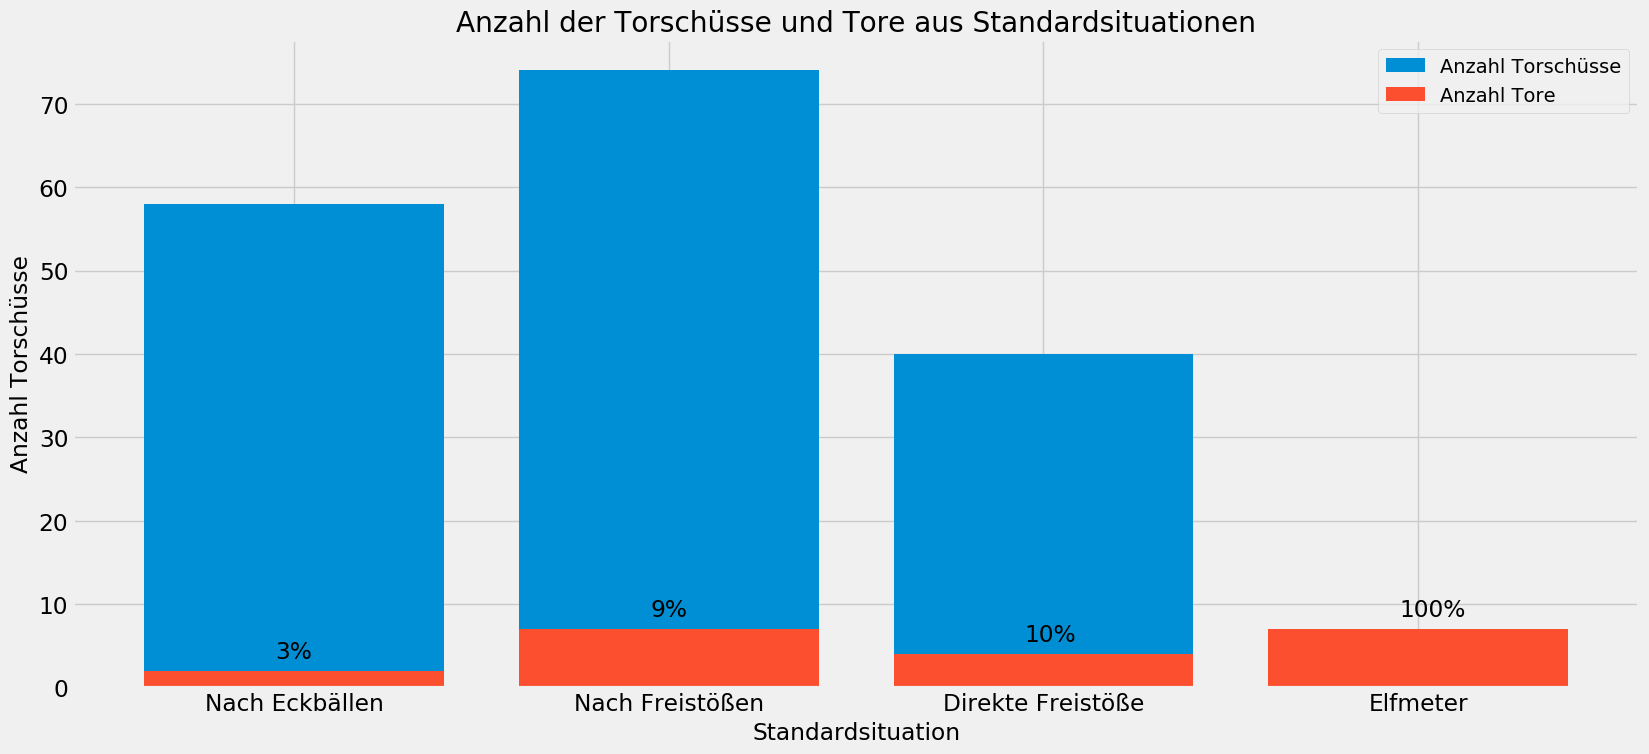

In [49]:
# Torschüsse und Tore in Abhängigkeit der Spielsituation
situations = ['from_corner', 'from_free_kick', 'free_kick', 'penalty'] 
x_labels = ['Nach Eckbällen', 'Nach Freistößen', 'Direkte Freistöße', 'Elfmeter']
goals = shots[shots['goal'] == 1]
num_goals = [len(goals[goals[situation] == 1]) if situation != 'from_free_kick' else len(goals[(goals['from_free_kick'] == 1) & (goals['free_kick'] == 0)]) for situation in situations]
num_shots = [len(shots[shots[situation] == 1]) if situation != 'from_free_kick' else len(shots[(shots['from_free_kick'] == 1) & (shots['free_kick'] == 0)]) for situation in situations]
pct_scored = [int(np.round(100 * num_goals[i] / num_shots[i])) for i in range(len(num_shots))]
plt.figure(figsize=(18,8))
plt.bar(x=x_labels, height=num_shots, label='Anzahl Torschüsse')
plt.bar(x=x_labels, height=num_goals, label='Anzahl Tore')
for i in range(len(situations)):
    plt.text(i - 0.05, num_goals[i] + 1.5, str(pct_scored[i]) + '%', fontsize='large')
plt.title('Anzahl der Torschüsse und Tore aus Standardsituationen')
plt.xlabel('Standardsituation')
plt.ylabel('Anzahl Torschüsse')
plt.legend()
plt.show()

In [50]:
goals = shots[shots['goal'] == 1]
len(goals[(goals['from_corner'] == 1) | (goals['free_kick'] == 1) | (goals['from_free_kick'] == 1) | (goals['penalty'] == 1)]) / len(goals)

0.3225806451612903